# <center> Individual Assignment </center>
##### <center> Author: Mikolaj Hilgert </center>

In [17]:
! pip install torch numpy matplotlib pandas seaborn -q

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 100
torch.manual_seed(SEED)
np.random.seed(SEED)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
class MyDataset(Dataset):  
    def __init__(self, csv_file, train=True, preview=False):
        self.train = train
        
        # Load data from CSV
        self.data = pd.read_csv(csv_file)

        if preview:
            print("Pairplot of 'train.csv'")
            sns.pairplot(self.data, diag_kind="kde")
            plt.show()
        
        # Drop the target feature
        features = self.data.drop(columns=["Rings"]) if train else self.data

        # OHE of Categorical (Sex) feature 
        sex_mapping = {"M": 0, "F": 1, "I": 2}
        sex_labels = features["Sex"].map(sex_mapping).values
        categorical_features = torch.nn.functional.one_hot(torch.tensor(sex_labels), num_classes=len(sex_mapping))

        # Select and standardize the numerical features
        numerical_features = torch.tensor(features.select_dtypes(include=["float"]).values, dtype=torch.float32)
        numerical_features = (numerical_features - numerical_features.mean(dim=0, keepdim=True)) / numerical_features.std(dim=0, keepdim=True)
        
        # Concatenate numerical and categorical features
        self.features = torch.cat((numerical_features, categorical_features), dim=1)

        # Use labels if training
        if train:
            self.labels = torch.tensor(self.data["Rings"].values, dtype=torch.float).unsqueeze(1)
        else:
            self.labels = None


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.train:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]


Pairplot of 'train.csv'


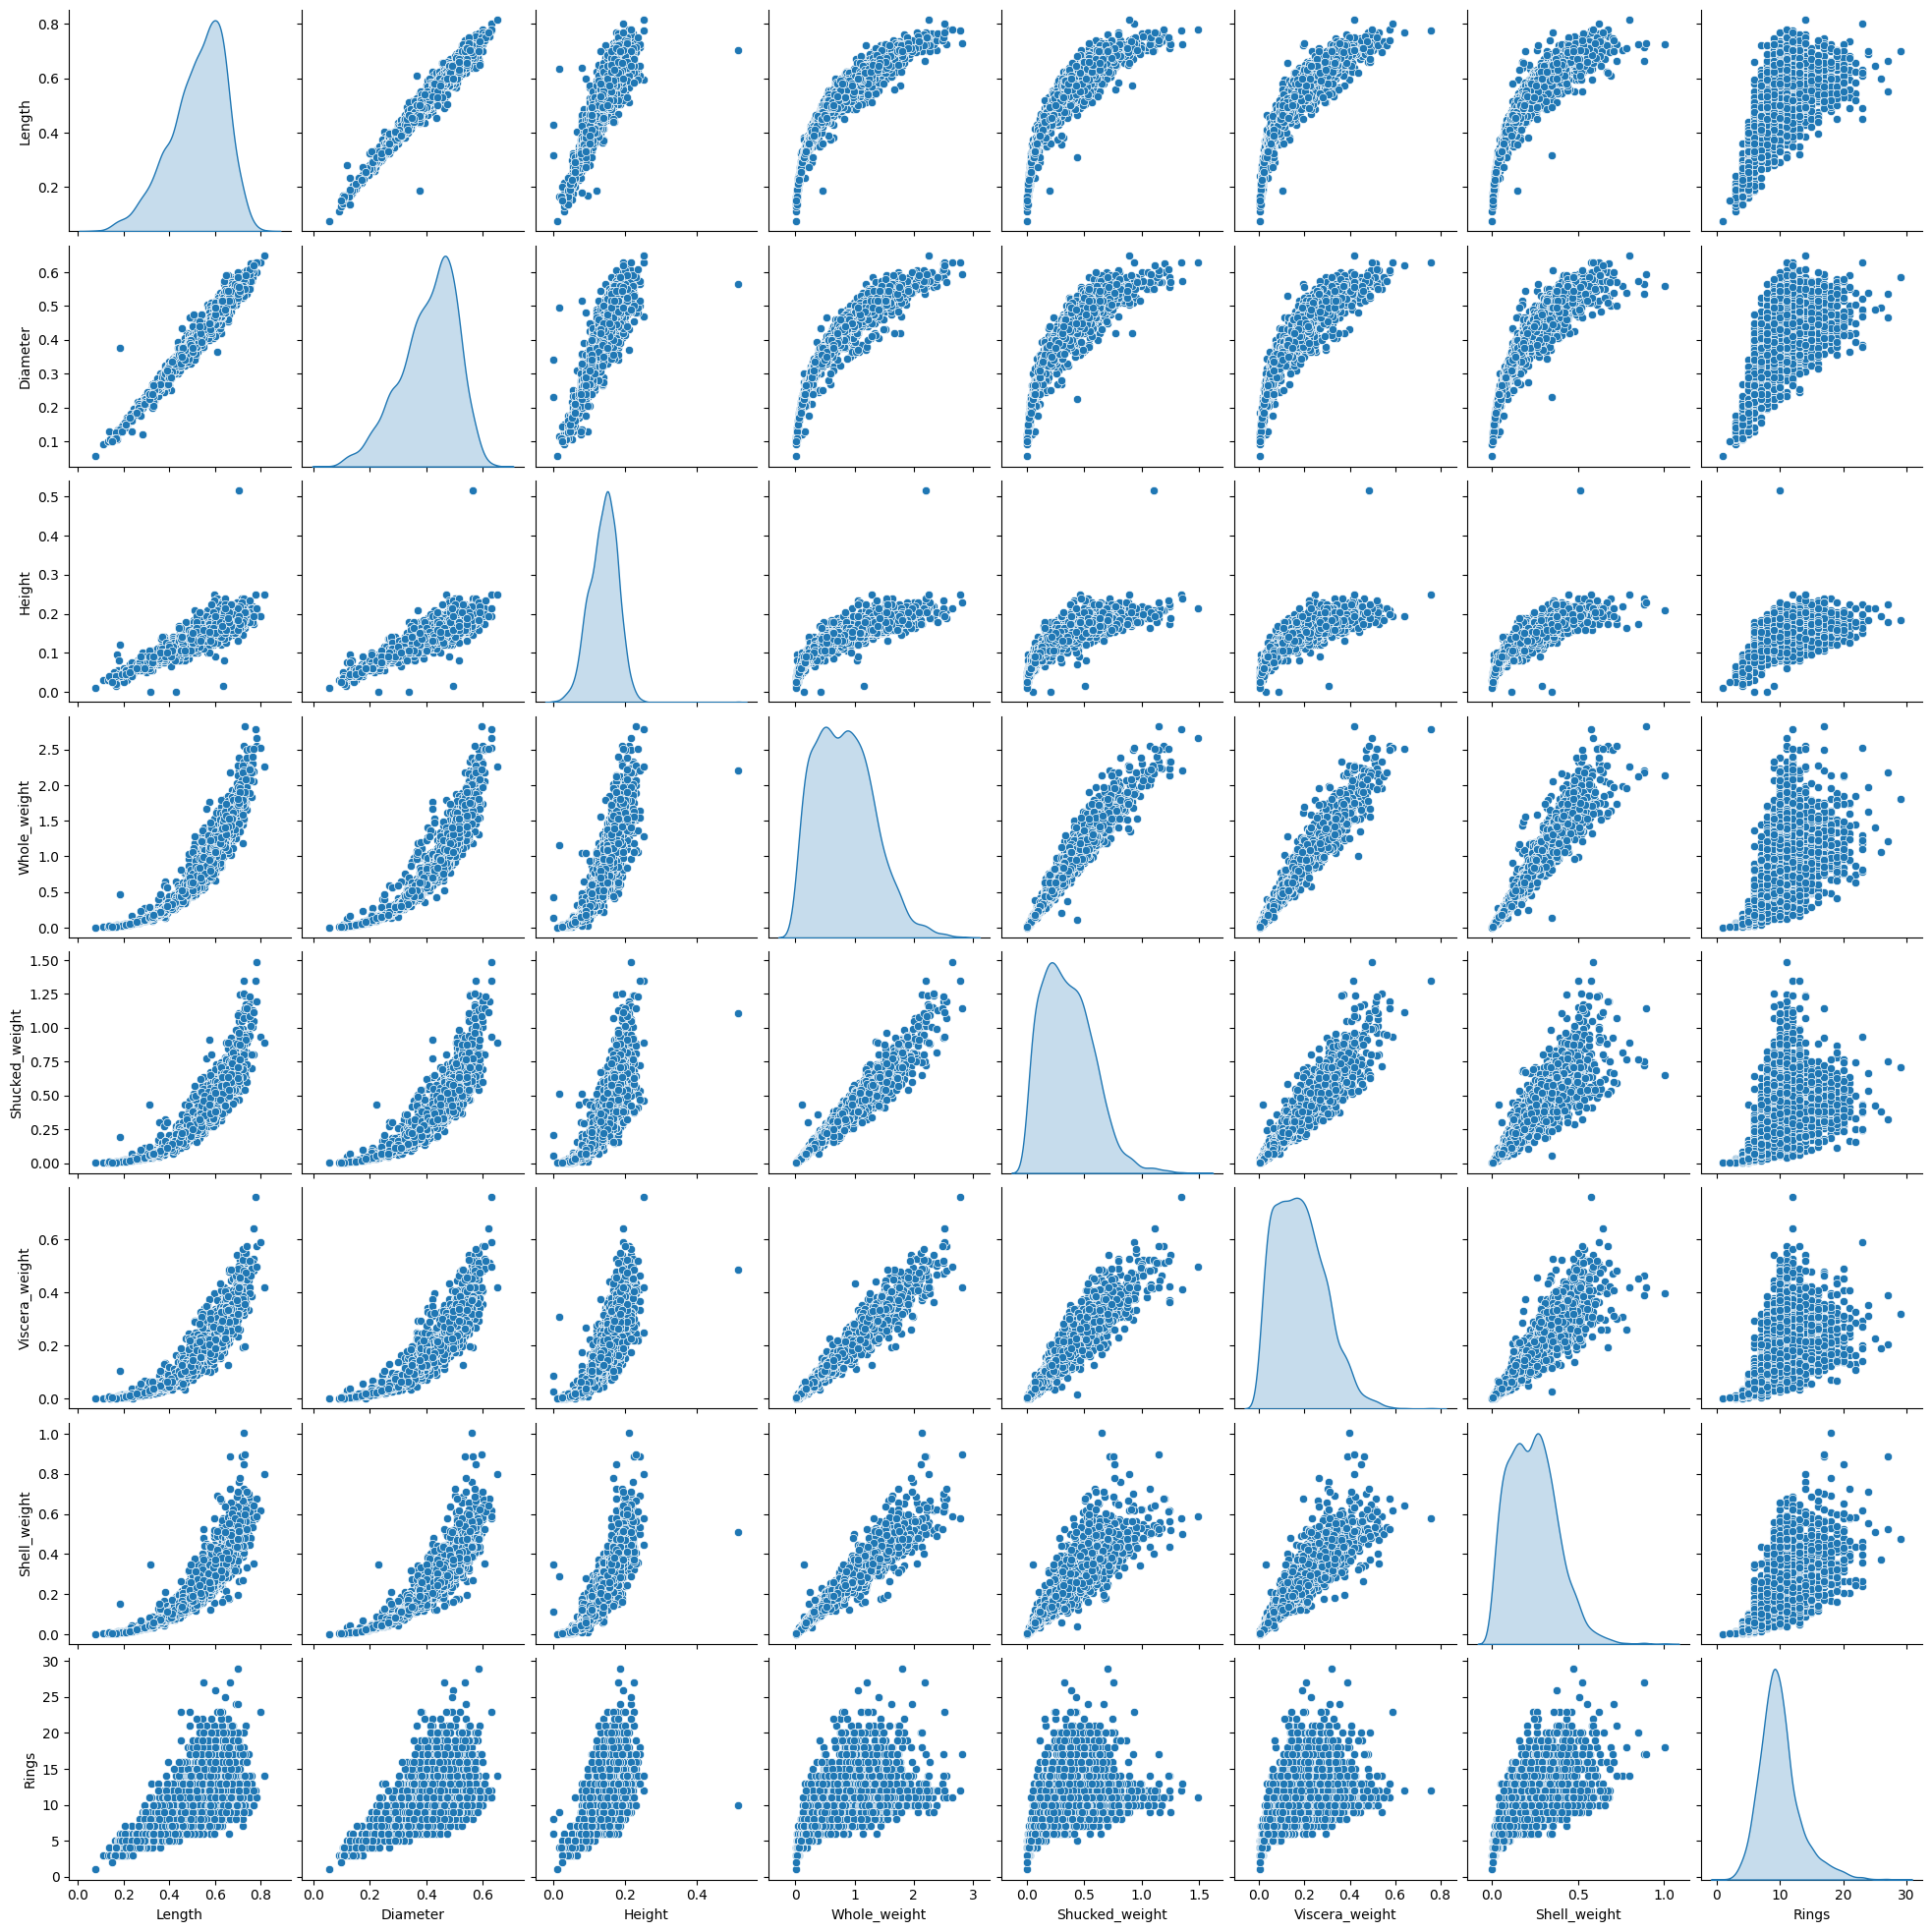

In [20]:
# Load the training dataset
train_dataset = MyDataset("data/train.csv", train=True, preview=True)
test_dataset = MyDataset("data/test.csv", train=False)

# Split the training data into training and validation sets (e.g., 80/20 split)
train_data, val_data = random_split(train_dataset, [0.8, 0.2])

# Create DataLoaders for mini-batch training
batch_size = 32 #32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
class MyMLP(nn.Module):
    def __init__(self, input_dim=10, hidden_dims=[64, 32], dropout_prob=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),  
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)  # Regression output
        )
    
    def forward(self, x):
        return self.fc(x)

# Instantiate the model
model = MyMLP()
print(model)

MyMLP(
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [22]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, device="cpu"):
    model.to(device)
    best_val_loss = 1e10
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * features.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), "best_model.pt")
    
    return train_losses, val_losses

# Set up training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Train the model
epochs = 50
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device)


Epoch 1/50 -- Train Loss: 28.4673 | Val Loss: 7.2774
Epoch 2/50 -- Train Loss: 5.7071 | Val Loss: 5.1832
Epoch 3/50 -- Train Loss: 5.6371 | Val Loss: 5.0316
Epoch 4/50 -- Train Loss: 5.4964 | Val Loss: 5.0199
Epoch 5/50 -- Train Loss: 5.3842 | Val Loss: 4.6743
Epoch 6/50 -- Train Loss: 5.2795 | Val Loss: 4.9218
Epoch 7/50 -- Train Loss: 5.4291 | Val Loss: 4.5347
Epoch 8/50 -- Train Loss: 5.3180 | Val Loss: 4.5323
Epoch 9/50 -- Train Loss: 5.1039 | Val Loss: 4.5203
Epoch 10/50 -- Train Loss: 5.0839 | Val Loss: 4.4750
Epoch 11/50 -- Train Loss: 5.0898 | Val Loss: 4.6537
Epoch 12/50 -- Train Loss: 4.9407 | Val Loss: 4.9000
Epoch 13/50 -- Train Loss: 5.0504 | Val Loss: 4.7106
Epoch 14/50 -- Train Loss: 4.8788 | Val Loss: 4.4723
Epoch 15/50 -- Train Loss: 4.9942 | Val Loss: 4.3409
Epoch 16/50 -- Train Loss: 4.9420 | Val Loss: 4.3226
Epoch 17/50 -- Train Loss: 4.9875 | Val Loss: 4.4260
Epoch 18/50 -- Train Loss: 4.8173 | Val Loss: 4.7993
Epoch 19/50 -- Train Loss: 4.8012 | Val Loss: 4.7128
E

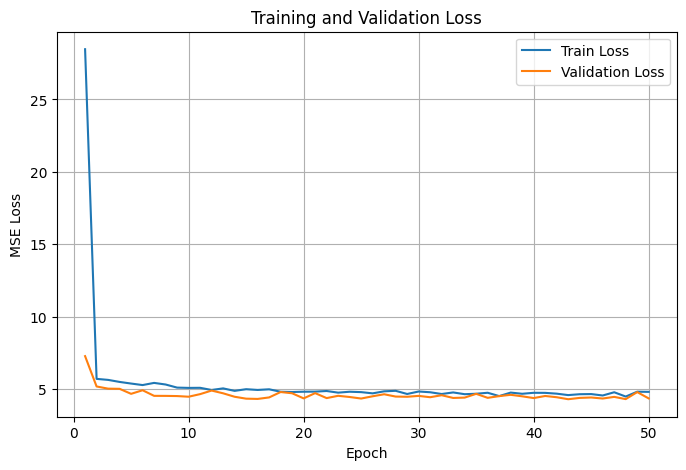

In [23]:
# Plot training and validation loss curves
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Load best model weights
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()

predictions = []
with torch.no_grad():
    for features in test_loader:
        features = features.to(device)
        outputs = model(features)
        # For regression, we can round the predictions to the nearest integer
        preds = outputs.squeeze().numpy()
        preds = np.rint(preds).astype(int)
        predictions.extend(preds.tolist())
        
# Write predictions to a new CSV file that contains all test columns plus a 'Rings' column
output_df = pd.read_csv("data/test.csv")
output_df['Rings'] = predictions
output_df.to_csv("test_with_predictions.csv", index=False)
